In [1]:
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pathlib import Path
from cartopy import crs as ccrs # Cartography library
import geopy.distance
import re
import pandas as pd
import cartopy.feature as cfeature
import matplotlib.patches as patches
import orcestra.sat

In [2]:
### Functions

In [3]:
### Function to convert latitude and longitudes from deg.min to deg dec
def ddm2dec(dms_str):
    """Return decimal representation of DDM (degree decimal minutes)
    
    >>> ddm2dec("45° 17,896' N")
    48.8866111111F
    """
    
    dms_str = re.sub(r'\s', '', dms_str)
    
    sign = -1 if re.search('[swSW]', dms_str) else 1
    
    numbers = [*filter(len, re.split('\D+', dms_str, maxsplit=4))]

    degree = numbers[0]
    minute_decimal = numbers[1] 
    decimal_val = numbers[2] if len(numbers) > 2 else '0' 
    minute_decimal += "." + decimal_val

    return sign * (int(degree) + float(minute_decimal) / 60)

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/var/folders/l3/7mstk0nx3_3c69r4z8lzlp0w0000gp/T/ipykernel_5802/2988614378.py:13: SyntaxWarning: invalid escape sequence '\D'
  numbers = [*filter(len, re.split('\D+', dms_str, maxsplit=4))]


In [4]:
def ec_track_meteor(data_log_time):
    day_ec = data_log_time.astype("datetime64[D]")
    dates_ec_hr = data_log_time.astype("datetime64[h]")
    issue_dates = day_ec
    valid_hour = dates_ec_hr
    issue_hours = [valid_hour + np.timedelta64(i, 'h') for i in range(-1, 2,2)]
    if  valid_hour > np.datetime64("2024-09-07T00:00:00"):
        roi = 'BARBADOS'
    else:
        roi = 'CAPE_VERDE'
    ec_track = orcestra.sat.SattrackLoader(
                "EARTHCARE", issue_dates, kind="PRE",roi=roi
            ).get_track_for_day(issue_dates).sel(
                time=slice(issue_hours[0],issue_hours[1]))
    return ec_track

In [5]:
### Link of the data
root = "ipfs://QmQArGny3Yt4axj4x8j228rQi7w2f3TsMx4U6bsoNkdQg8"

In [6]:
### Calling radiosondes from METEOR
ds_radios= xr.open_dataset(
    f"{root}/RS_METEOR_level2.zarr",engine="zarr").rename({'sounding':'time'})
##ascending radisondes
ds_radios_asc = ds_radios.where(ds_radios.ascent_flag==0,drop=True)
##make the launch time the axis time
ds_radios_asc['time'] = ds_radios_asc.launch_time.squeeze().values

In [7]:
### Calling Dship data
ds_dship= xr.open_dataset(f"{root}/DShip.zarr",engine="zarr")

In [8]:
### Read data log
file_log = '/Users/hans/Documents/bow_tie/log_ship/M203-StationList_md.csv'
data_raw = pd.read_csv(file_log,header=0,sep=';',usecols=[1, 2, 3, 4, 5, 7],dtype={'Date': str, 'Time [UTC]': str})
                     #  parse_dates=[[0,2]],dayfirst='True',date_format='%d.%m.%Y %H:%M:%S')
data_raw = data_raw.rename(columns={'Latitude [°]': 'Lat','Longitude [°]': 'Lon'})
data_raw['datetime']= pd.to_datetime(data_raw.pop('Date')+' '+data_raw.pop('Time [UTC]'),
                                                                          format ='%d.%m.%y %H:%M:%S')
data_raw = data_raw.set_index('datetime')
data_raw['Lat'] = [ddm2dec(data_raw['Lat'].iloc[i]) for i in range(data_raw.shape[0])]
data_raw['Lon'] = [ddm2dec(data_raw['Lon'].iloc[i]) for i in range(data_raw.shape[0])]

In [9]:
### read data log for coordinated points
file_coord_log = '/Users/hans/Documents/bow_tie/log_ship/coordination_log.xlsx'
data_ex = pd.read_excel(file_coord_log,header=0,dtype={'Time begin (UTC)': str})
data_ex = data_ex.rename(columns={'Latitude (°N)': 'Lat','Longitude (°W)': 'Lon'})
data_ex['datetime']= pd.to_datetime(data_ex.pop('Date').dt.strftime('%d.%m.%y')+' '+data_ex.pop('Time begin (UTC)'),
                                                                          format ='%d.%m.%y %H:%M:%S')
data_ex = data_ex.set_index('datetime')
dates_log = data_ex[data_ex['Overpass device'].str.contains('EC')].index.values
track_ec = [ec_track_meteor(time_index) for time_index in dates_log]

In [12]:
## select incubation and plankton
regex_incu = r'incubation'
regex_plankton = r'plankton'
data_incu = data_raw[data_raw['Remarks'].str.contains(regex_incu)]
data_plankton = data_raw[data_raw['Remarks'].str.contains(regex_plankton)]
#Zones of studies
###zone 1
zones = data_raw[(data_raw['Gear']=='GLIDER') | (data_raw['Gear']=='DRIFT')]
coord_zn1 = [zones[0:8]['Lon'].min(),zones[0:8]['Lon'].max(),zones[0:8]['Lat'].min(),zones[0:8]['Lat'].max()]
###zone 2
coord_zn2 = [zones[8:18]['Lon'].min(),zones[8:18]['Lon'].max(),zones[8:18]['Lat'].min(),zones[8:18]['Lat'].max()]
###zone 3
coord_zn3 = [zones[18:]['Lon'].min(),zones[18:]['Lon'].max(),zones[18:]['Lat'].min(),zones[18:]['Lat'].max()]

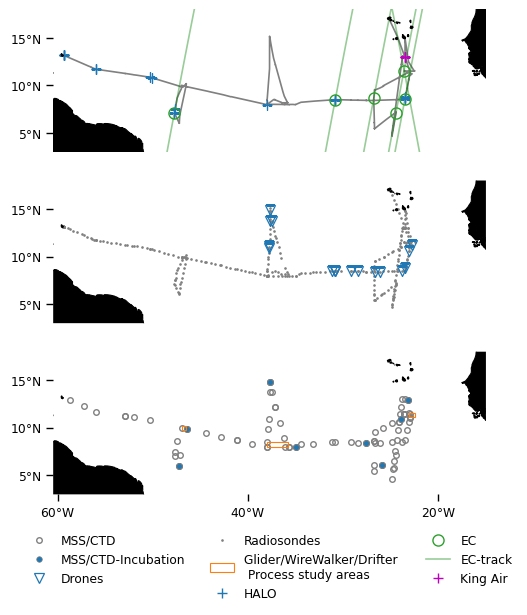

In [41]:
###Plotting the ship track
sns.set_context("paper")
fig = plt.figure(figsize=(16/2.54,16/2.54))
ax = fig.add_subplot(311,projection=ccrs.PlateCarree())
ax.set_extent([-60.5, -15, 3, 18], crs=ccrs.PlateCarree())

plt.plot(ds_dship.lon,ds_dship.lat,'-',color='gray')

l1=plt.plot(data_ex[data_ex['Overpass device']=='HALO']['Lon']*-1,
         data_ex[data_ex['Overpass device']=='HALO']['Lat'],'+',color='tab:blue',markersize=7,zorder=8,markeredgewidth=1,
         markerfacecolor="None",label = 'HALO')

l2=plt.plot(data_ex[data_ex['Overpass device']=='EC']['Lon']*-1,
         data_ex[data_ex['Overpass device']=='EC']['Lat'],'o',color='tab:green',markersize=8,zorder=8,markeredgewidth=1,
         markerfacecolor="None",label = 'EC')

l3=plt.plot(data_ex[data_ex['Overpass device']=='King Air']['Lon']*-1,
         data_ex[data_ex['Overpass device']=='King Air']['Lat'],'+',color='m',markersize=7,zorder=8,markeredgewidth=1,
         markerfacecolor="None",label = 'King Air')

[plt.plot(track_ec[idx].lon,
          track_ec[idx].lat,'-g',alpha=0.4) for idx in range(len(track_ec)-1)]
l4 = plt.plot(track_ec[-1].lon,track_ec[-1].lat,'-g',alpha=0.4,label='EC-track')

ax.add_feature(cfeature.LAND,zorder=10,color='k')
ax.spines.geo.set_visible(False)
ax.set_yticks(np.arange(5,18,5))
ax.set_yticklabels([r'5$\degree$N',r'10$\degree$N',r'15$\degree$N'])
ax.set_xticklabels({})
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_title(None)

ax = fig.add_subplot(312,projection=ccrs.PlateCarree())
ax.set_extent([-60.5, -15, 3, 18], crs=ccrs.PlateCarree())
l5 = plt.plot(ds_radios_asc.lon.isel(alt=10), ds_radios_asc.lat.isel(alt=10),'o',markersize=0.9,color='gray',label='Radiosondes')
ax.add_feature(cfeature.LAND,zorder=10,color='k')
l6=plt.plot(data_raw[data_raw['Gear']=='UAV']['Lon'],
         data_raw[data_raw['Gear']=='UAV']['Lat'],'v',color='tab:blue',markersize=7,markeredgewidth=0.9,zorder=12,markerfacecolor="None", label = 'Drones')
ax.spines.geo.set_visible(False)
ax.set_yticks(np.arange(5,18,5))
ax.set_yticklabels([r'5$\degree$N',r'10$\degree$N',r'15$\degree$N'])
ax.set_xticklabels({})
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_title(None)


ax = fig.add_subplot(313,projection=ccrs.PlateCarree())
ax.set_extent([-60.5, -15, 3, 18], crs=ccrs.PlateCarree())

l7=plt.plot(data_raw[data_raw['Gear']=='CTD']['Lon'],
         data_raw[data_raw['Gear']=='CTD']['Lat'],'o',color='gray',markersize=4,zorder=8,markeredgewidth=1,
         markerfacecolor="None",label = 'MSS/CTD')
plt.plot(data_plankton['Lon'],data_plankton['Lat'],'o',color='gray',markersize=4,zorder=12,markeredgewidth=1,
        markerfacecolor="None")

l8=plt.plot(data_incu['Lon'],data_incu['Lat'],'o',color='tab:blue',markersize=4,zorder=12,
            markeredgewidth=0.5, markeredgecolor='gray',label = 'MSS/CTD-Incubation')

zone_1 = patches.Rectangle((coord_zn1[0],coord_zn1[2]),coord_zn1[1]-coord_zn1[0],coord_zn1[3]-coord_zn1[2],
                               zorder=14,edgecolor='tab:orange',facecolor="None",label='Glider/WireWalker/Drifter \n Process study areas')
zone_2 = patches.Rectangle((coord_zn2[0],coord_zn2[2]),coord_zn2[1]-coord_zn2[0],coord_zn2[3]-coord_zn2[2],
                               zorder=14,edgecolor='tab:orange',facecolor="None",label='Glider/WireWalker/Drifter \n Process study areas')
zone_3 = patches.Rectangle((coord_zn3[0],coord_zn3[2]),coord_zn3[1]-coord_zn3[0],coord_zn3[3]-coord_zn3[2],
                               zorder=14,edgecolor='tab:orange',facecolor="None",label='Glider/WireWalker/Drifter \n Process study areas')

l9 = ax.add_patch(zone_1)
ax.add_patch(zone_2)
ax.add_patch(zone_3)

ax.add_feature(cfeature.LAND,zorder=10,color='k')
ax.spines.geo.set_visible(False)
ax.set_yticks(np.arange(5,18,5))
ax.set_xticks(np.arange(-60,-9,20))
ax.set_yticklabels([r'5$\degree$N',r'10$\degree$N',r'15$\degree$N'])
ax.set_xticklabels([r'60$\degree$W',r'40$\degree$W',r'20$\degree$W'])
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_title(None)

lns = l7+l8+l6+l5+[l9]+l1+l2+l4+l3
labs = [l.get_label() for l in lns]
ax.legend(lns,labs,loc='upper center', bbox_to_anchor=(0.5, -0.2),
          ncol=3,frameon=False)

plt.savefig('../figures/ship_track_and_instruments_triple_plot.png',
            dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})

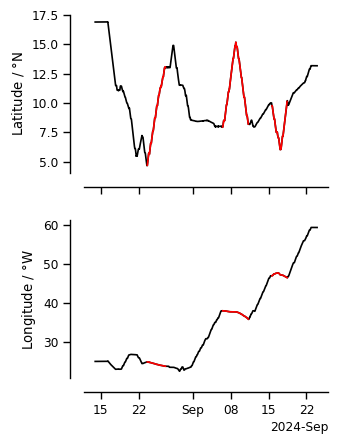

In [12]:
###Plotting the ship track
sns.set_context("paper")
fig = plt.figure(figsize=(8/2.54,12/2.54))
ax = fig.add_subplot(211)
ds_dship.lat.plot(color='k')
sns.despine(offset=10,ax=ax)
ds_dship.sel(time=slice('2024-08-23 15:00:00','2024-08-26 23:00')).lat.plot(color='r')
ds_dship.sel(time=slice('2024-09-06 13:00:00','2024-09-11 06:00')).lat.plot(color='r')
ds_dship.sel(time=slice('2024-09-15 15:00:00','2024-09-18 10:00')).lat.plot(color='r')
ax.set_ylabel(r"Latitude / $\degree$N")
ax.set_xticklabels({})
ax.set_xlabel(None)

ax = fig.add_subplot(212)
(ds_dship.lon*-1).plot(color='k')
(ds_dship.sel(time=slice('2024-08-23 15:00:00','2024-08-26 23:00')).lon*-1).plot(color='r')
(ds_dship.sel(time=slice('2024-09-06 13:00:00','2024-09-11 06:00')).lon*-1).plot(color='r')
(ds_dship.sel(time=slice('2024-09-15 15:00:00','2024-09-18 10:00')).lon*-1).plot(color='r')
sns.despine(offset=10,ax=ax)
ax.set_ylabel(r"Longitude / $\degree$W")
plt.subplots_adjust(hspace=0.3)
ax.set_xlabel(None)
plt.savefig('../figures/ship_track_latitude_longitude.pdf',
            format='pdf',bbox_inches='tight',orientation={'landscape'})